In [11]:
import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn

%matplotlib inline

In [12]:
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map
print(dyn.cities)
# dyn.draw_map()

['Lausanne', 'Geneva', 'Sion', 'Neuchâtel', 'Basel', 'Bern', 'Lücern', 'St-Gallen', 'Zürich']


In [257]:
SCALE = 100
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4


def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    if a == ACTION_CONFINE:
        action['confinement'] = True
    elif a == ACTION_ISOLATE:
        action['isolation'] = True
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = True
    elif a == ACTION_HOSPITAL:
        action['hospital'] = True
        
    return action
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    # confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    return torch.Tensor(np.stack((infected,dead))).unsqueeze(0)

In [258]:
action_space        =   spaces.Discrete(5)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
print(f"sampled action : {action_space.sample()}")
# print("Sampled observation")
# plt.matshow(observation_space.sample()[0,:,:])
# plt.show()

sampled action : 3


In [259]:
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

In [260]:
from matplotlib.ticker import MultipleLocator

def runSimulation(env, agent, epsilon = None, seed = 0):
    """ Run the simulation """
    log = []
    rewards_logs = []
    obs_logs = []
    obs, info = env.reset(seed)
    finished = False
    while not finished:
        if epsilon is None:
            action = agent.act(obs)
        else:
            action = agent.act(obs, epsilon)
        obs, R, finished, info = env.step(action)
        log.append(info) # save the information dict for logging
        rewards_logs.append(R.item()) # save penalted reward's
        obs_logs.append(obs) # save observation's
        if finished:
            break


    """ Parse the logs """
    total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
    cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
    actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}
    
    return total, cities, actions, rewards_logs, obs_logs


def plotSimulation(total, cities, actions):
    
    fig = plt.figure(figsize=(14,10))
    ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
    ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
    ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
    ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
    ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
    ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

    [ax_leftstate.plot(y) for y in total.values()]
    ax_leftstate.legend(total.keys())
    ax_leftstate.set_title('Full state')
    ax_leftstate.set_ylabel('number of people in each state')

    [ax_leftobs.plot(total[y]) for y in ['infected','dead']]
    ax_leftobs.legend(['infected','dead'])
    ax_leftobs.set_title('Observable state')
    ax_leftobs.set_ylabel('number of people in each state')

    ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
    ax_leftactions.set_title('Actions')
    ax_leftactions.set_yticks([0,1,2,3])
    ax_leftactions.set_yticklabels(list(actions.keys()))
    ax_leftactions.set_xlabel('time (in weeks)')

    [ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
    [ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
    [ax.set_ylabel(c) for c, ax in ax_right.items()]
    [ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
    ax_right['Zürich'].set_xlabel('time (in weeks)')
    ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

    fig.tight_layout()

    plt.show()

### Question 1.a

Run the epidemic simulation for one episode (30 weeks), without epidemic mitigation (meaning no action is
taken, i.e. all values in the action dictionary are set to False)

In [261]:
class NullAgent(Agent):
    def __init__(self,  env:Env,
                # Additionnal parameters to be added here
                ):
        """
        Null agent implementation. Perform no action at each time step.
        """
        self.env = env
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,):
        # This should be called when the environment is reset
        pass
    
    def act(self, obs):
        # this takes an observation and returns an action
        # the action space can be directly sampled from the env
        return 0 

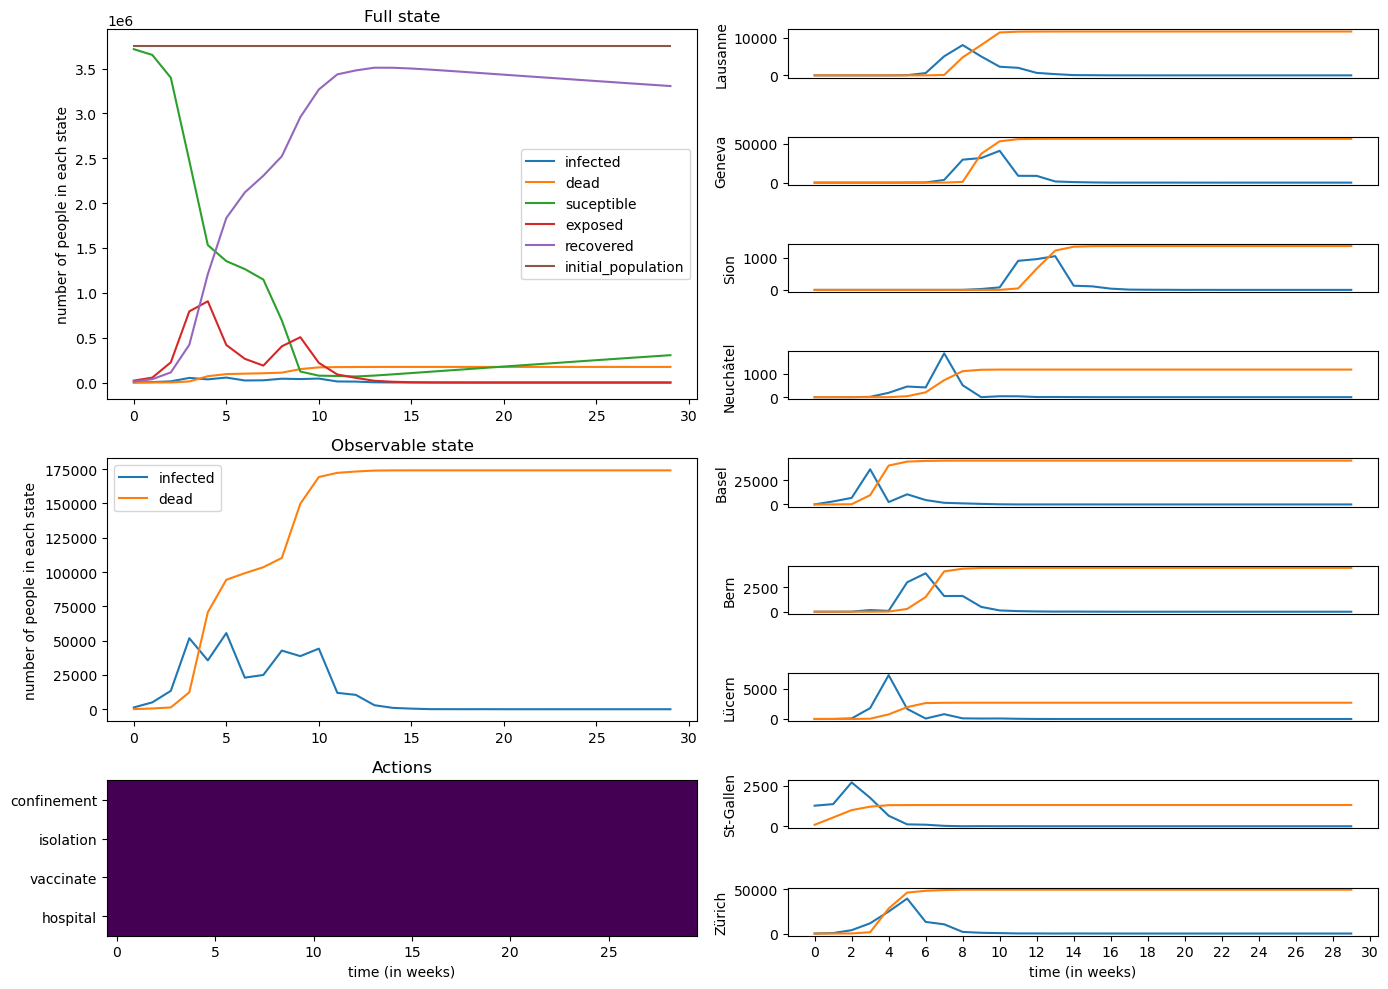

In [262]:
null_agent = NullAgent(env)
total, cities, actions, _, _ = runSimulation(env, null_agent)
plotSimulation(total, cities, actions)

Here we do not perform any action during the whole period (30 weeks).
With time number of dead people increases (sharply from week 3 to 5 and from week 8 to 10), while the number of infected people is about 50000 from week 3 to week 10 and then decrease.
Overall, it look like pandemia needs several weeks to pick up stream and then it rages for some time causing deaths growing. 
Starting from week 10-12 less people are susceptible to the virus and therefore almost no new deaths and infections happens.
<br>
Looking into cities level, we can notice that the bahaviour of two main characteristics is pretty similar to what we see on the general plot.
Hence, in each city there is a peak of infection lasting for couple of weeks and then number of dead and infected stables.
The closer city to the source of infection, the earlier this peak happens.
<br>
<b>When we do not mitigate the infection, it finishes anyway some time later with the total number of deaths about 175000</b>

### Question 2.a

Since the epidemic hit Listenburg before Switzerland, the listenburgish medical community has had time to
study the epidemic behavior of the disease and one of the listenburgish experts, professor Russo, suggests the
following mitigation policy: 
<br>
<b>if number of infected people at the end of the week is bigger than 200000, then confine the entire country for 4 weeks.</b>
<br>
The number of infected cases is not evaluated during a confinement period, i.e. if the policy declares a
4-week confinement starting at week w and the number of infected people is still > 200000 at week w + 2, a new
4-week confinement does not start at w + 2

In [265]:
class RussoAgent(Agent):
    def __init__(self,  env:Env
                # Additionnal parameters to be added here
                ):
        """
        Agent based on Russo policy implementation.
        """
        self.env = env
        self.activatated_russo=False
        self.russo_steps=0
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,):
        # This should be called when the environment is reset
        pass
    
    def act(self, obs):
        # this takes an observation and returns an action
        # the action space can be directly sampled from the env
        total_infected=0
        # print(dyn.get_action())
        for ind,city in enumerate(self.env._get_info().city.keys()):
            total_infected+=(obs[:,0,ind,-1])/100*self.env._get_info().city[city].initial_population
            
        if total_infected>20000 and not self.activatated_russo:
            self.activatated_russo=True

        if self.activatated_russo:
            if self.russo_steps<4:
                self.russo_steps+=1
            else:
                self.activatated_russo=False
                self.russo_steps=0

        if self.activatated_russo:
            return 1
        else:
            return 0

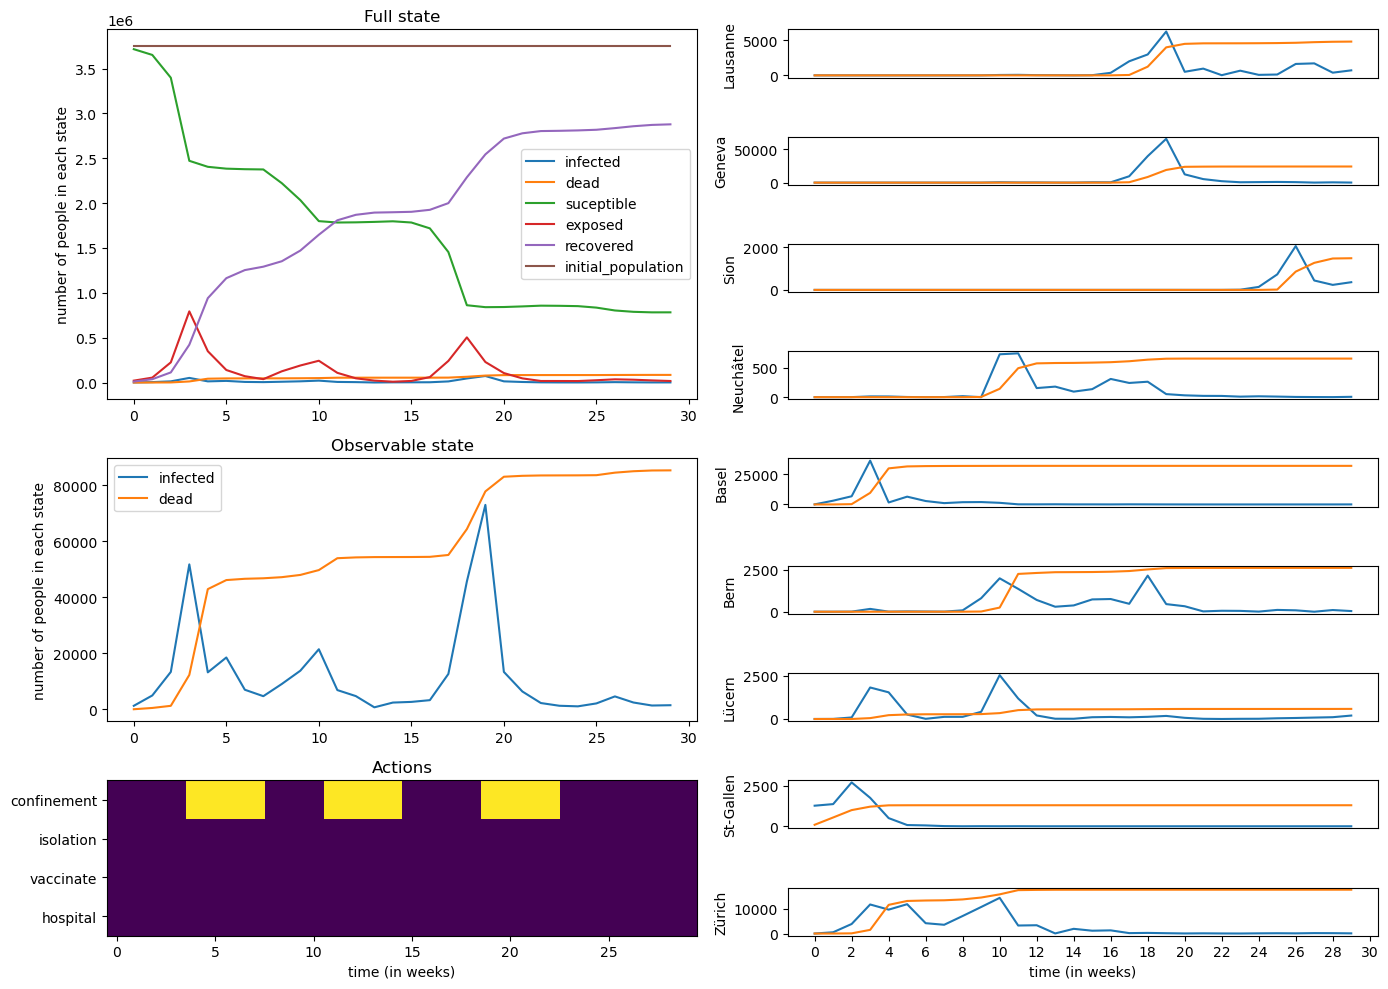

In [266]:
russo_agent = RussoAgent(env)
total, cities, actions, _, obs_logs = runSimulation(env, russo_agent)
plotSimulation(total, cities, actions)

Here we used Russo policy (did <i>confinement</i> for 4 weeks when the total number of infected is greater than 20000).
<br>
In total, there were 3 peaks of infections (weeks 3, 10 and 19) when this confinement was applied. 
It should be mentioned that those peaks happen at the same time when there are peaks in number of exposed people. 
After the <i>confinement</i> action is performed, we can see that the total number of infected people decreases and the number of deaths increases less sharply.
<br>
From the level of cities, there are also 1-2 peaks of infections happening at the same time as peaks in the whole country that is quite obvious.
<br>

<br>
<b>Finally, using this policy the total number of deaths is about 85000 that is twice less than with NullAgent</b>


### Question 2.b

In order to be able to make meaningful conclusions about the behavior of the policy, you will need properly evaluate its behavior. To do so, running a single episode is not enough. Implement the following evaluation procedure: run 50 simulation episodes where actions are chosen from policy π (in this case π will be πRusso, but you should make the effort to write evaluation code in which you can easily change the policy being evaluated as you will be asked to evaluate each policy you train later). For each episode, save the following values:
1. the **number of total confined days $N_{confinement}$** = 7 · number of confined weeks ,
2. the **cumulative reward** (the sum of all rewards collected during the episode) $R_{cumulative} = \sum_{i∈[0,...,30]}R^{[i]}$.
3. the **number of total deaths** $N_{deaths} = d^{[30]}_{total}$

Make sure to always be using the same sequence of random seeds (see the tutorial notebook for details on the environment seed) when evaluating different policies, in order to ensure that results are repoducible. (To check that they are, run the eval twice, and check that you get the same average values). Once those values are logged for each episode, plot a histogram. (Use the histogram plotting function from the tutorial notebook.)

In [267]:
def runMultipleEpisodes(env, agent, num_episodes = 50, epsilon = None, seed=0):
    n_confinement_days = []
    n_isolation_days = []
    total_reward = []
    n_deaths = []
    for _ in range(num_episodes):
        seed+=1
        total, cities, actions, rewards, _ = runSimulation(env, agent, epsilon, seed)
        n_confinement_days.append(7*np.sum(actions['confinement']))
        n_isolation_days.append(7*np.sum(actions['isolation']))
        total_reward.append(np.sum(rewards))
        n_deaths.append(total['dead'][-1])
    return n_confinement_days, n_isolation_days, total_reward, n_deaths

In [268]:
def plotHistograms(n_confinement_days, n_isolation_days, total_reward, n_deaths):
    
    """ Plot example """
    fig, ax = plt.subplots(3,2,figsize=(18,8))
    def hist_avg(ax, data,title):
        ymax = 50
        if title == 'deaths':
            x_range = (1000,200000)
        elif title == 'cumulative rewards': 
            x_range = (-300,300)
        elif 'days' in title:
            x_range = (0,200)
        else:
            raise ValueError(f'{title} is not a valid title') 
        ax.set_title(title)
        ax.set_ylim(0,ymax)
        ax.vlines([np.mean(data)],0,ymax,color='red')
        ax.hist(data,bins=60,range=x_range)
        
    hist_avg(ax[0,0], n_deaths, 'deaths')
    hist_avg(ax[1,0], total_reward,'cumulative rewards')
    hist_avg(ax[2,0], n_confinement_days,'confined days')
    fig.tight_layout()
    plt.show()

    """ Print example """
    print(f'Average death number: {np.mean(n_deaths)}')
    print(f'Average number of confined days: {np.mean(n_confinement_days)}')
    print(f'Average cumulative reward: {np.mean(total_reward)}')

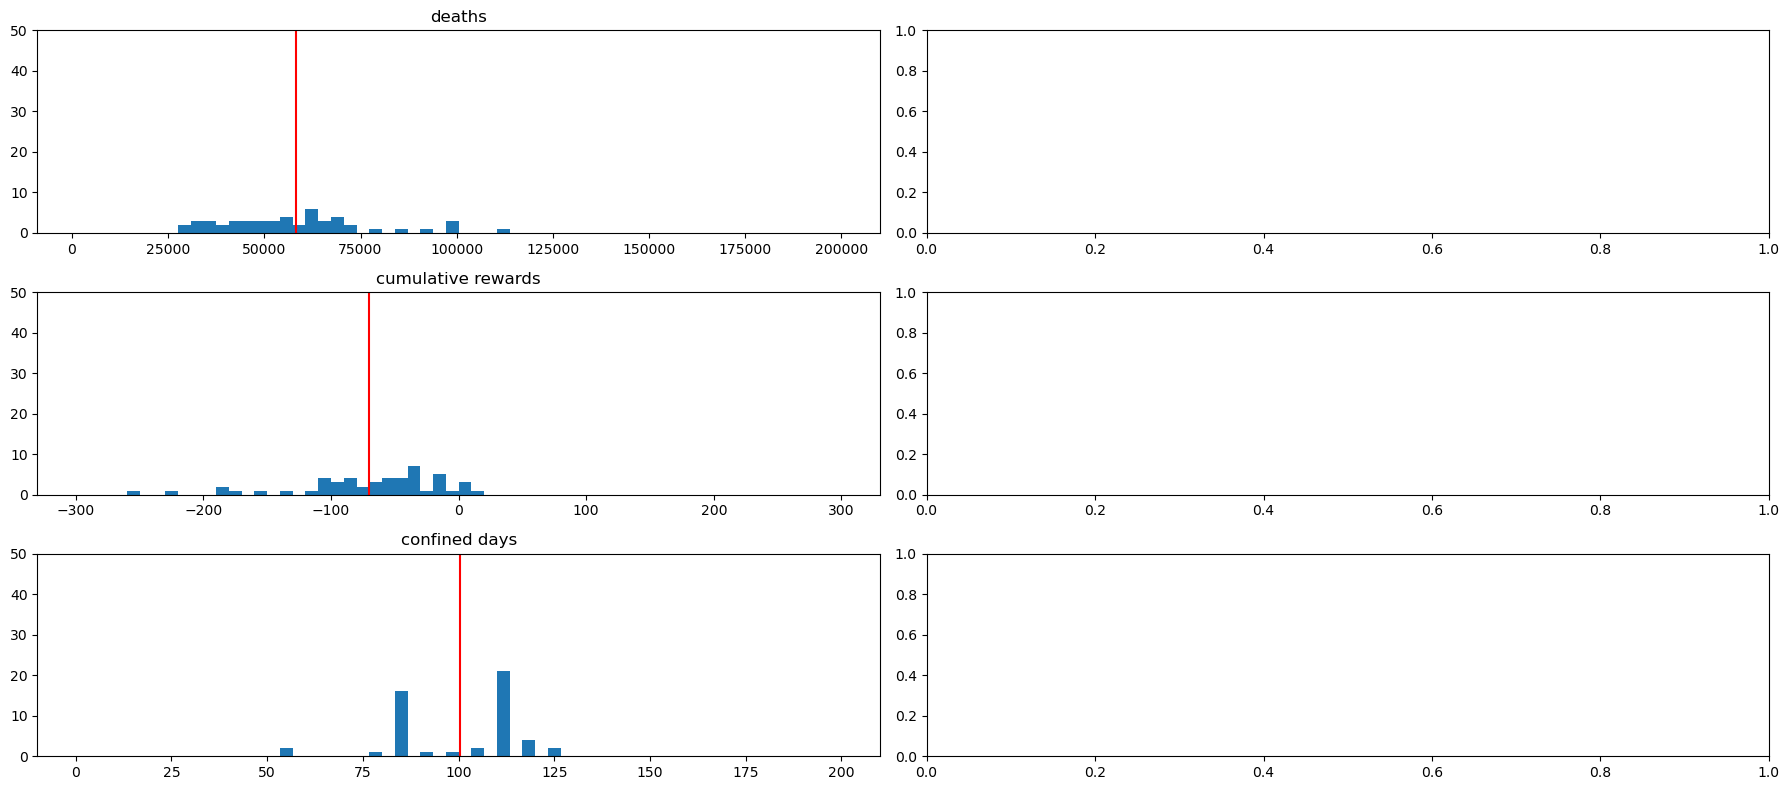

Average death number: 58202.56
Average number of confined days: 100.24
Average cumulative reward: -70.28866780832642


In [269]:
russo_agent = RussoAgent(env)
n_confinement, n_isolation_days, total_reward, n_deaths = runMultipleEpisodes(env, russo_agent, num_episodes=50)
plotHistograms(n_confinement, n_isolation_days, total_reward, n_deaths)

## Question 3

In [275]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from tqdm import trange
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [276]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self._storage = []
        self._maxsize = capacity

    def push(self, *args):
        """Save a transition"""
        self._storage.append(Transition(*args))
        
        if len(self._storage) > self._maxsize:
            self._storage = self._storage[-self._maxsize:]

    def sample(self, batch_size):
        return random.sample(self._storage, batch_size)

    def __len__(self):
        return len(self._storage)

In [277]:
class DQNAgent(nn.Module):
    def __init__(self, obs_dim, n_actions):

        super().__init__()
        self.n_actions = n_actions

        self.net = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, n_actions),
        ) 

    def forward(self, state_t):
        """
        takes agent's observation (tensor), returns qvalues (tensor)
        :param state_t: a batch of observations
        """
        # Use your network to compute qvalues for given state
        qvalues = self.net(state_t).to(device)
        return qvalues
    
    def act(self, obs, epsilon):
        """pick actions given observation. Uses epsilon-greedy exploration strategy. """
        # get q_values
        qvalues = self.net(obs.reshape(1, -1).to(device)).data.cpu().numpy()
                    
        if random.random() < epsilon:
            # random action for exploration 
            return np.random.choice(self.n_actions)
        # best action for exploitation
        return qvalues.argmax(axis=-1)[0] 

In [278]:
BUFFER_SIZE = 20000 # number of samples in buffer
BATCH_SIZE = 2048 # number of transitions sampled from the replay buffer
GAMMA = 0.9 # discount factor as mentioned in the previous section
EPS_0 = 0.7 # epsilon
EPS_MIN = 0.2
TAU = 5 # target update rate
LR = 5*1e-3 # the learning rate of the ``AdamW`` optimizer

# Get number of actions from gym action space
n_actions = 2
# Get the number of state observations
state, info = env.reset()
OBS_DIM = len(state.reshape(-1, 1))

# max grad norm for clipping
max_grad_norm = 50

In [279]:
def computeLoss(agent_net, target_net, memory):
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch 
    batch = Transition(*zip(*transitions))
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None]).reshape(-1, OBS_DIM).to(device)
    
    state_batch = torch.cat(batch.state).reshape(BATCH_SIZE, OBS_DIM).to(device)
    action_batch = torch.tensor(batch.action)
    reward_batch = torch.tensor(batch.reward).to(device)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to agent_net
    state_action_values = agent_net(state_batch)[np.arange(BATCH_SIZE), action_batch]
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values)
    
    return loss

In [280]:
def trainDQN(agent_net, target_net, optimizer, memory, epsilon_decrease=False, num_episodes = 500, eval_freq = 50):
    train_rewards_logs = []        
    eval_rewards_logs = []

    for i_episode in trange(num_episodes):
        # variables for reward and time penalty
        cumulative_reward = 0
        # value of epsilon
        eps = EPS_0
        if epsilon_decrease:
            eps = max(eps*(1-i_episode / num_episodes), EPS_MIN)
        # Initialize the environment and get it's state
        state, info = env.reset()
        finished = False
        while not finished:
            action = agent_net.act(state.to(device), eps)
            next_state, reward, finished, info = env.step(action)
            
            cumulative_reward += reward.squeeze().item()
            
            if finished:
                next_state = None

            # Store the transition in memory
            memory.push(state, action, next_state, reward.squeeze().item())

            # Move to the next state
            state = next_state

            if len(memory) >= BATCH_SIZE:
                # Compute Loss
                loss = computeLoss(agent_net, target_net, memory)

                # Optimize the model
                optimizer.zero_grad()
                loss.backward()
                # In-place gradient clipping
                torch.nn.utils.clip_grad_value_(agent_net.parameters(), max_grad_norm)
                optimizer.step()
            
        train_rewards_logs.append(cumulative_reward)

        if i_episode % TAU == 4 or i_episode == num_episodes - 1:
            target_net.load_state_dict(agent_net.state_dict())

        if i_episode % eval_freq == eval_freq - 1 or i_episode == num_episodes - 1:
            eval_cummulative_rewards = runMultipleEpisodes(env, agent_net, num_episodes=20, epsilon = 0)[2]
            eval_rewards_logs.append(np.mean(eval_cummulative_rewards))
            
    return agent_net, train_rewards_logs, eval_rewards_logs

In [281]:
def plot_train_rewards(train_rewards):
    
    plt.figure(figsize=[16, 5])
    
    for i in range(len(train_rewards)):
        plt.subplot(1, len(train_rewards), i+1)
        plt.title(f"Training Reward {i+1}")
        plt.scatter(np.arange(len(train_rewards[i])), train_rewards[i])
        plt.grid()

    plt.show()

In [282]:
def plot_eval_rewards(eval_rewards):
    mean_rewards=np.array(eval_rewards).mean(axis=0)
    
    plt.figure(figsize=[16, 5])
    
    plt.subplot(1, 1, 1)
    plt.title(f"Mean avaluation reward")
    plt.plot(np.arange(len(mean_rewards)), mean_rewards)
    plt.grid()

    plt.show()

## Question 3.a

In [284]:
nets=[]
train_rewards=[]
eval_rewards=[]

for i in range (3):
    agent_net = DQNAgent(OBS_DIM, n_actions).to(device)
    target_net = DQNAgent(OBS_DIM, n_actions).to(device)
    target_net.load_state_dict(agent_net.state_dict())

    optimizer = optim.AdamW(agent_net.parameters(), lr=LR, amsgrad=True)
    memory = ReplayMemory(BUFFER_SIZE)
    
    agent_net, train_rewards_logs, eval_rewards_logs = trainDQN(agent_net, target_net, optimizer, memory, epsilon_decrease=False)
    
    nets.append(agent_net)
    train_rewards.append(train_rewards_logs)
    eval_rewards.append(eval_rewards_logs)

100%|██████████| 500/500 [10:23<00:00,  1.25s/it]


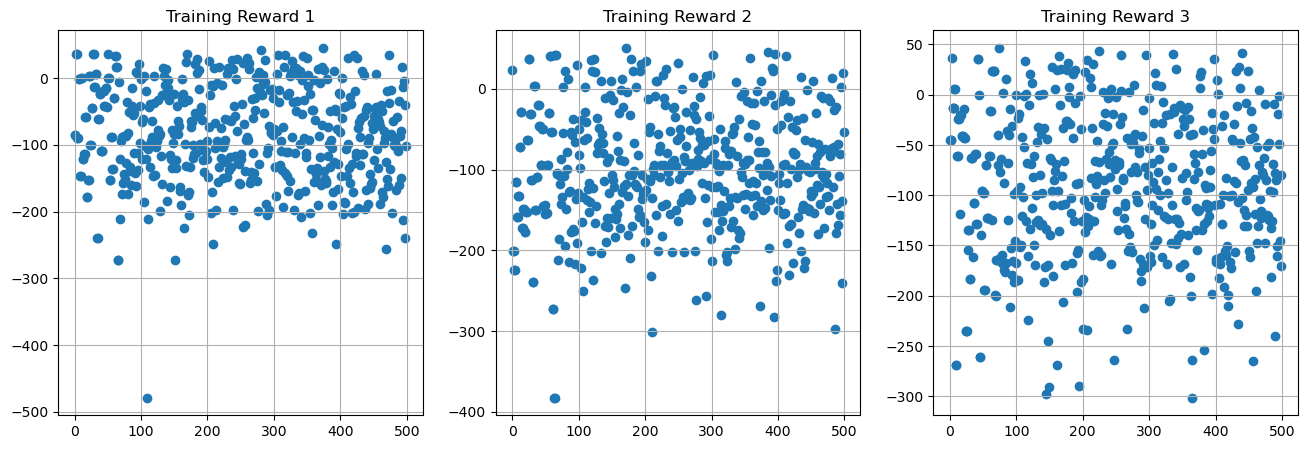

In [285]:
plot_train_rewards(train_rewards)

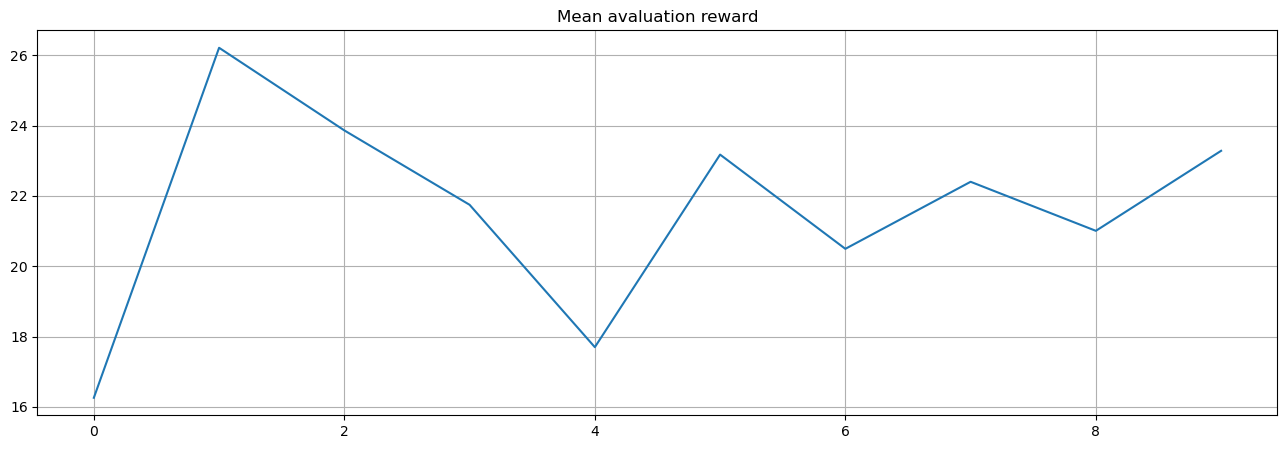

In [286]:
plot_eval_rewards(eval_rewards)

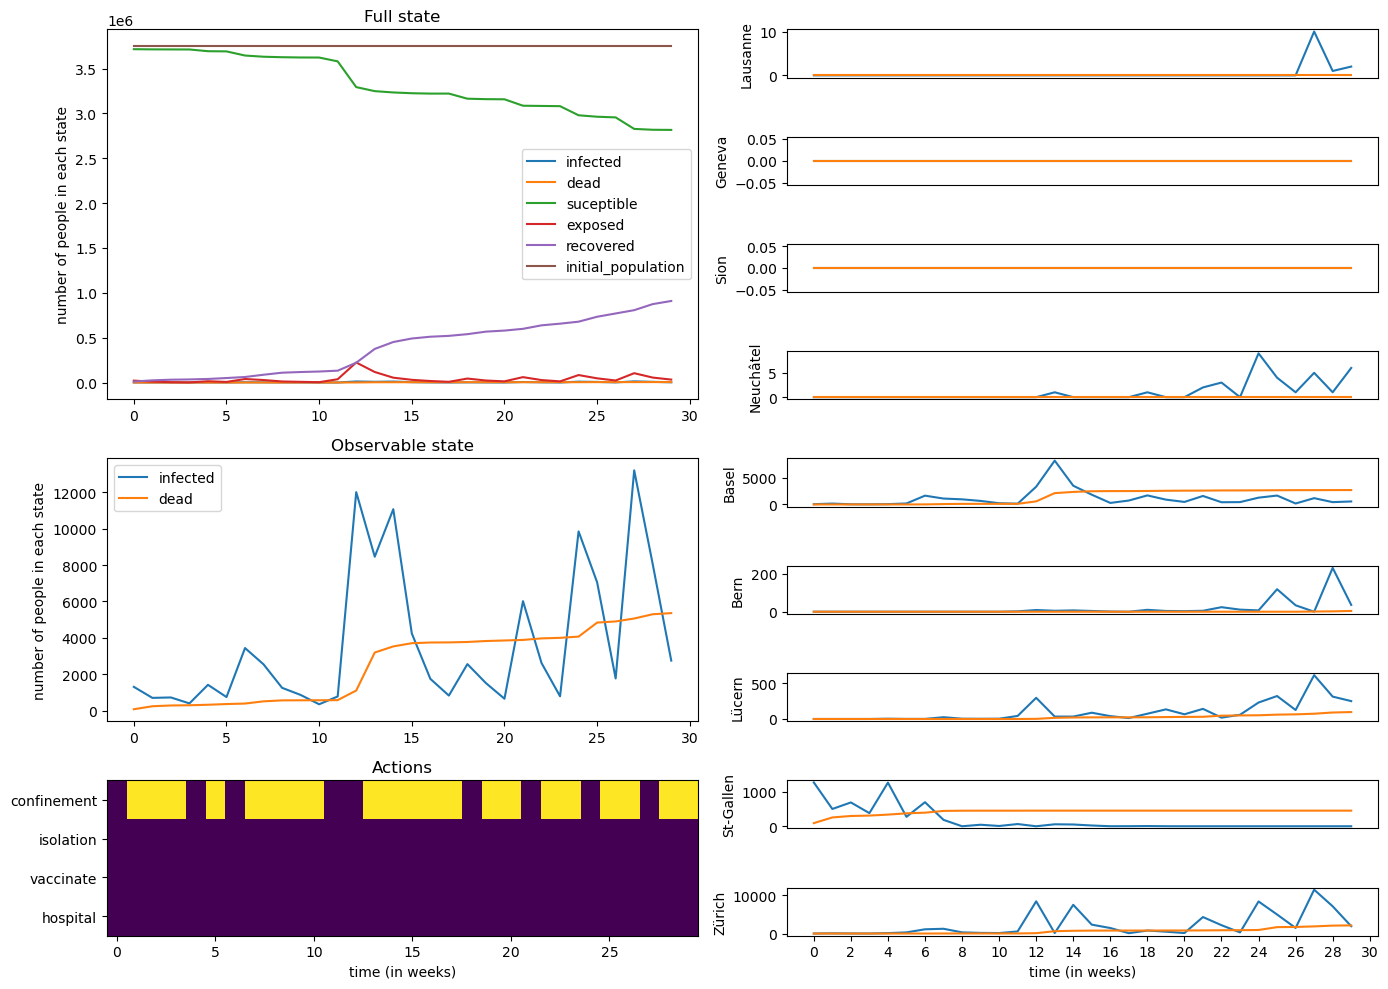

In [306]:
best_agent_ind=np.array(eval_rewards)[:,-1].argmax()
best_agent=nets[best_agent_ind]
total, cities, actions, _, _ = runSimulation(env, best_agent,epsilon=0)
plotSimulation(total, cities, actions)

In [307]:
checkpoint_path = 'DQN_3A.pth'
torch.save({'agent_state_dict': best_agent.state_dict(),}, checkpoint_path)

## Question 3b

In [289]:
nets_=[]
train_rewards_=[]
eval_rewards_=[]

for i in range (3):

    agent_net = DQNAgent(OBS_DIM, n_actions).to(device)
    target_net = DQNAgent(OBS_DIM, n_actions).to(device)
    target_net.load_state_dict(agent_net.state_dict())

    optimizer = optim.AdamW(agent_net.parameters(), lr=LR, amsgrad=True)
    memory = ReplayMemory(BUFFER_SIZE)
    
    agent_net, train_rewards_logs, eval_rewards_logs = trainDQN(agent_net, target_net, optimizer, memory, epsilon_decrease=True)
    
    nets_.append(agent_net)
    train_rewards_.append(train_rewards_logs)
    eval_rewards_.append(eval_rewards_logs)

100%|██████████| 500/500 [09:40<00:00,  1.16s/it]


In [298]:
def compare_plots(train_rewards_1,train_rewards_2,eval_rewards_1,eval_rewards_2):
    mean_train_rewards_1=np.array(train_rewards_1).mean(axis=0)
    mean_train_rewards_2=np.array(train_rewards_2).mean(axis=0)
    
    mean_eval_rewards_1=np.array(eval_rewards_1).mean(axis=0)
    mean_eval_rewards_2=np.array(eval_rewards_2).mean(axis=0)
    
    plt.figure(figsize=[16, 9])
    
    plt.subplot(1, 2, 1)
    plt.title(f"Training Rewards")
    plt.scatter(np.arange(len(mean_train_rewards_1)), mean_train_rewards_1)
    plt.scatter(np.arange(len(mean_train_rewards_2)), mean_train_rewards_2)
    plt.legend(["constant exploration rate=0.7","decreasing exploration rate (from 0.7 to 0.2)"])
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.title(f"Evaluation rewards")
    plt.plot(np.arange(len(mean_eval_rewards_1)), mean_eval_rewards_1)
    plt.plot(np.arange(len(mean_eval_rewards_2)), mean_eval_rewards_2)
    plt.legend(["constant exploration rate=0.7","decreasing exploration rate (from 0.7 to 0.2)"])
    plt.grid()

    plt.show()

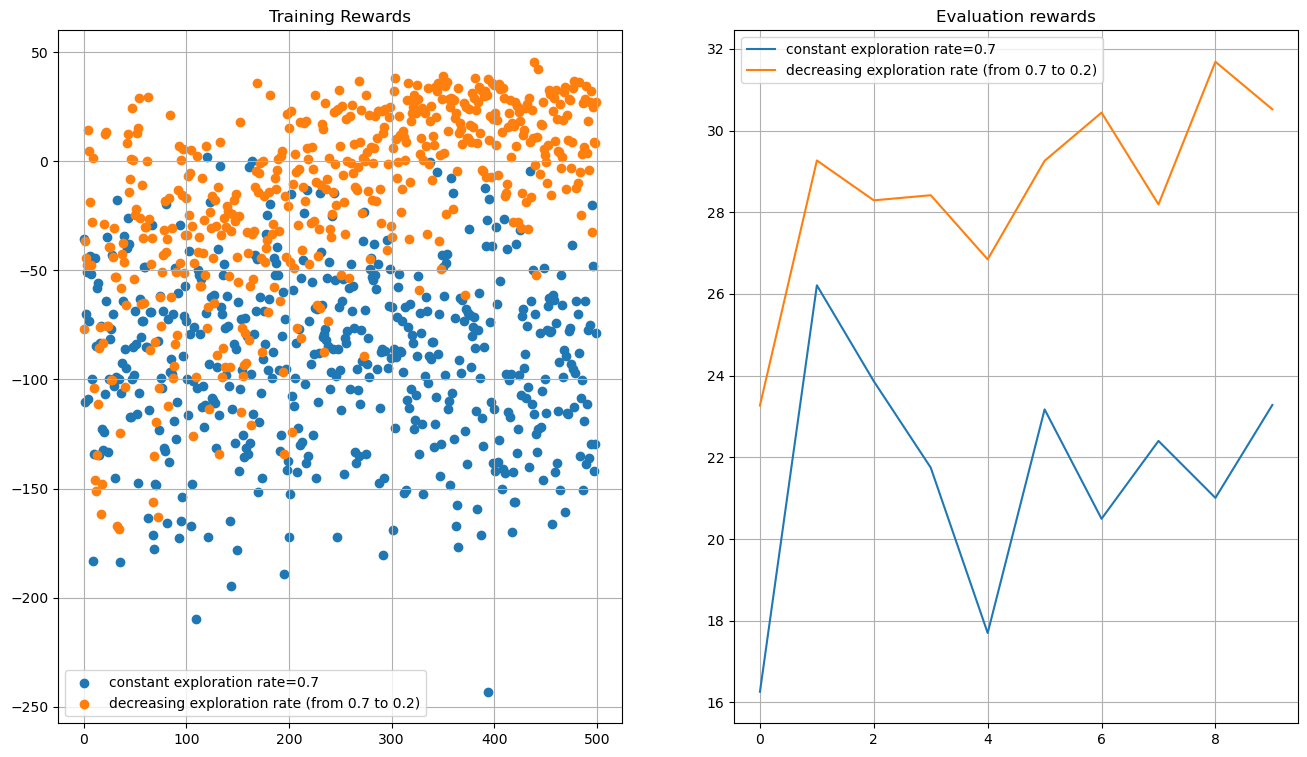

In [299]:
compare_plots(train_rewards,train_rewards_,eval_rewards,eval_rewards_)

In [304]:
best_agent_ind_=np.array(eval_rewards_)[:,-1].argmax()
best_agent_=nets_[best_agent_ind_]

In [305]:
checkpoint_path = 'DQN_3B.pth' 
torch.save({'agent_state_dict': best_agent_.state_dict(),}, checkpoint_path)

In [ ]:
#save checkpoint
import pickle
with open('3a.pkl', 'wb') as f:
    pickle.dump([nets,train_rewards,eval_rewards], f)
f.close()
with open('3b.pkl', 'wb') as f:
    pickle.dump([nets_,train_rewards_,eval_rewards_], f)
f.close()


f = open('3a.pkl', 'rb')
nets,train_rewards,eval_rewards = pickle.load(f)
f.close()
f = open('3b.pkl', 'rb')
nets_,train_rewards_,eval_rewards_ = pickle.load(f)
f.close()

Ideas for improving performance:
   * Fill reply buffer before training

## Question 3c

##### DQN

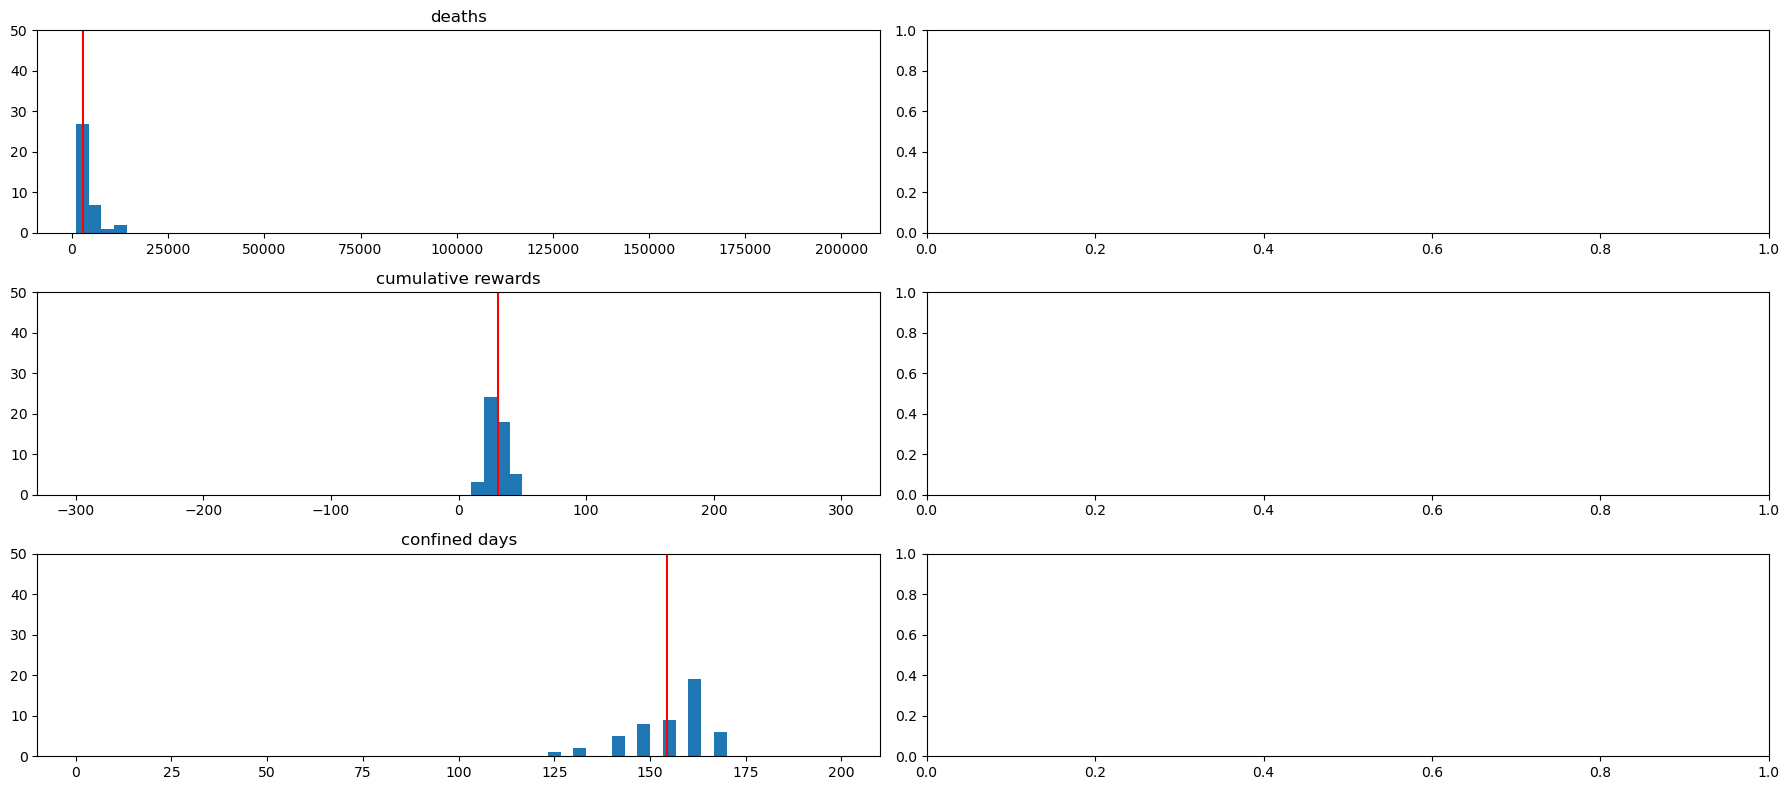

Average death number: 2997.78
Average number of confined days: 154.42
Average cumulative reward: 30.486648447737096


In [308]:
n_confinement, n_isolation_days, total_reward, n_deaths = runMultipleEpisodes(env, best_agent_, num_episodes=50, epsilon = 0)
plotHistograms(n_confinement, n_isolation_days, total_reward, n_deaths)

##### Russo

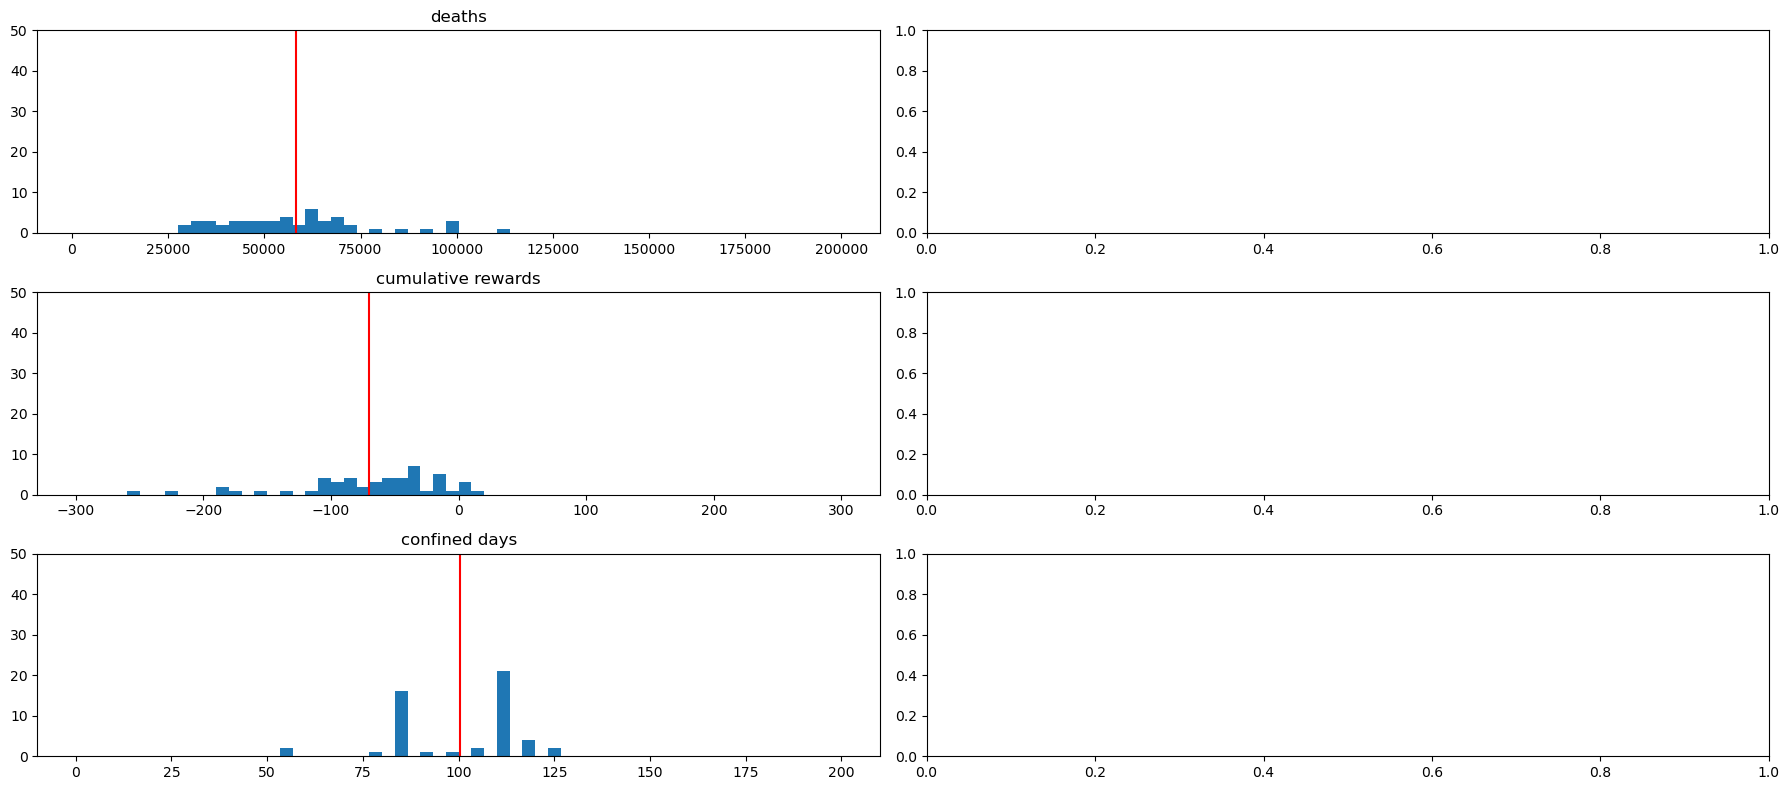

Average death number: 58202.56
Average number of confined days: 100.24
Average cumulative reward: -70.28866780832642


In [309]:
russo_agent = RussoAgent(env)
n_confinement, n_isolation_days, total_reward, n_deaths = runMultipleEpisodes(env, russo_agent, num_episodes=50)
plotHistograms(n_confinement, n_isolation_days, total_reward, n_deaths)

# Question 4.1.a

# Question 4.1.b

In [323]:
SCALE = 100
ACTION_NULL = 0
ACTION_TOGGLE_CONFINE = 1
ACTION_TOGGLE_ISOLATE = 2
ACTION_TOGGLE_HOSPITAL = 3
ACTION_TOGGLE_VACCINATE = 4

def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = dyn.get_action().copy()
    if a == 1:
        action['confinement'] = not action['confinement']
    elif a == 2:
        action['isolation'] = not action['isolation']
    elif a == 3:
        action['hospital'] = not action['hospital']
    elif a == 4:
        action['vaccinate'] = not action['vaccinate']
        
    return action
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    state = torch.Tensor(list(dyn.get_action().values()))

    return torch.cat((torch.Tensor(np.stack((infected, dead))).reshape(-1), state))

In [324]:
action_space        =   spaces.Discrete(5)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
print(f"sampled action : {action_space.sample()}")
# print("Sampled observation")
# plt.matshow(observation_space.sample()[0,:,:])
# plt.show()
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

LR = 1e-5
state, info = env.reset()
n_actions = 5
OBS_DIM = len(state)

sampled action : 3


In [325]:
nets=[]
train_rewards=[]
eval_rewards=[]

for i in range (3):
    agent_net = DQNAgent(OBS_DIM, n_actions).to(device)
    target_net = DQNAgent(OBS_DIM, n_actions).to(device)
    target_net.load_state_dict(agent_net.state_dict())

    optimizer = optim.AdamW(agent_net.parameters(), lr=LR, amsgrad=True)
    memory = ReplayMemory(BUFFER_SIZE)

    agent_net, train_rewards_logs, eval_rewards_logs = trainDQN(agent_net, target_net, optimizer, memory, epsilon_decrease=True)

    nets.append(agent_net)
    train_rewards.append(train_rewards_logs)
    eval_rewards.append(eval_rewards_logs)

100%|██████████| 500/500 [10:13<00:00,  1.23s/it]


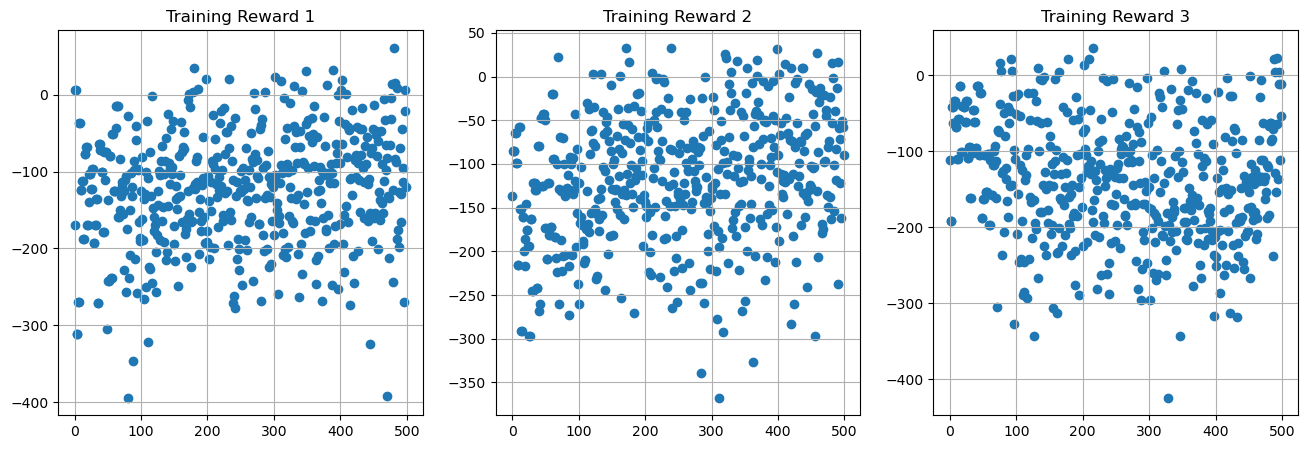

In [326]:
plot_train_rewards(train_rewards)

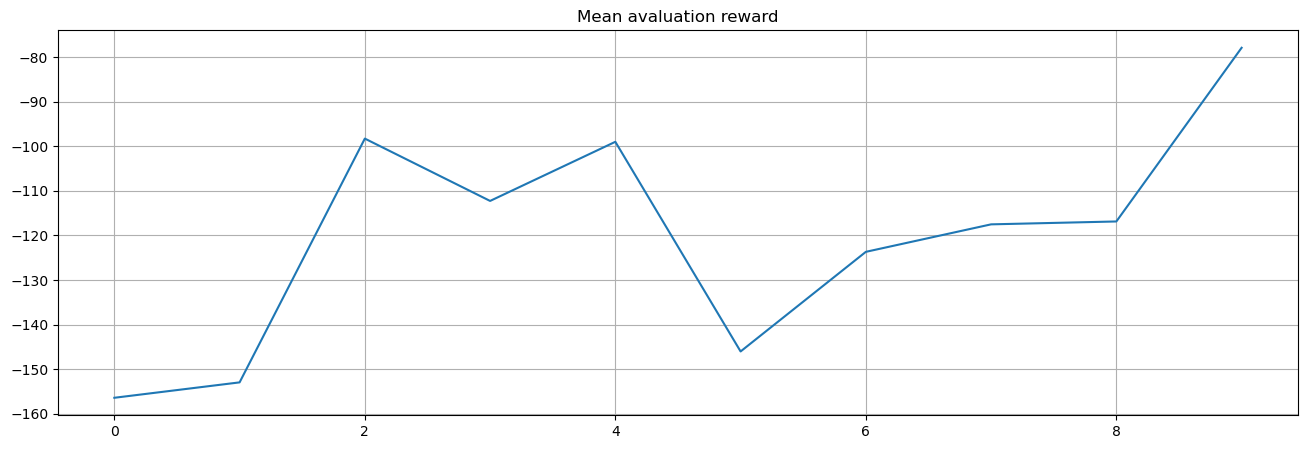

In [327]:
plot_eval_rewards(eval_rewards)

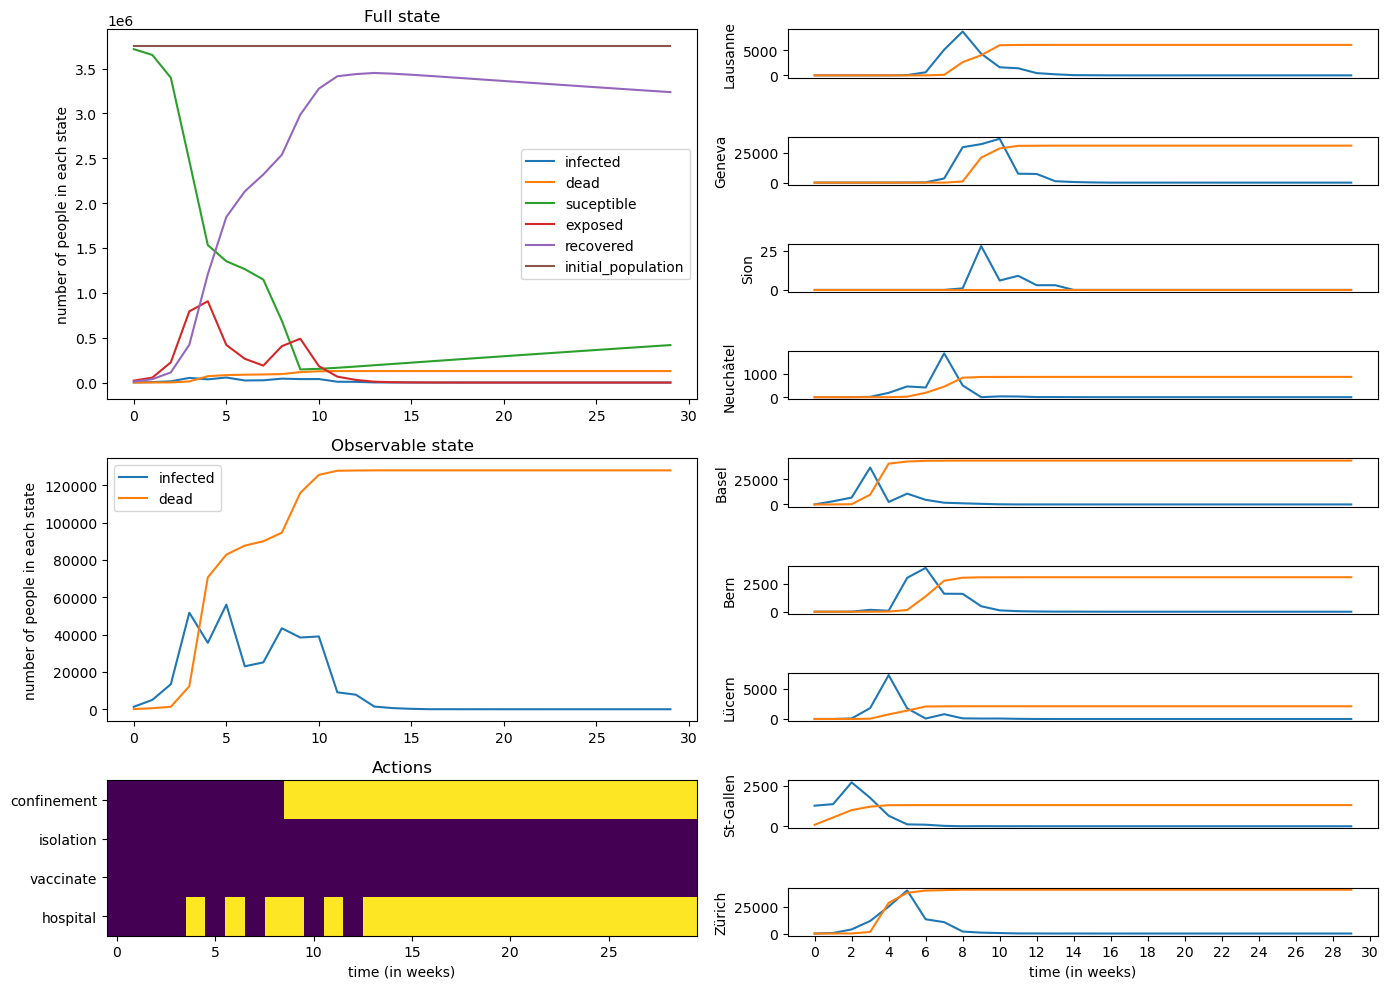

In [328]:
best_agent_ind=np.array(eval_rewards)[:, -1].argmax()
best_agent=nets[best_agent_ind]
total, cities, actions, _, _ = runSimulation(env, best_agent,epsilon=0)
plotSimulation(total, cities, actions)

In [ ]:
checkpoint_path = 'DQN_4A1.pth' 
torch.save({'agent_state_dict': best_agent.state_dict(),}, checkpoint_path)

In [329]:
import pickle
with open('4a1.pkl', 'wb') as f:
    pickle.dump([nets,train_rewards,eval_rewards], f)
f.close()

# f = open('4a1.pkl', 'rb')
# nets,train_rewards,eval_rewards = pickle.load(f)
# f.close()

# Question 4.1.c

In [ ]:
n_confinement, n_isolation_days, total_reward, n_deaths = runMultipleEpisodes(env, best_agent, num_episodes=50)
plotHistograms(n_confinement, n_isolation_days, total_reward, n_deaths)

# Question 4.1.d